In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [4]:
feat_names = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry",
    "length_groove",
]

target_name = ["species"]

col_names = feat_names + target_name

<IPython.core.display.Javascript object>

In [6]:
# Data downloaded from this link:
# https://archive.ics.uci.edu/ml/datasets/seeds
# More info on the data can be seen there.
data_path = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
)
seeds = pd.read_csv(data_path, sep="\t+", header=None, names=col_names, engine="python")
seeds.head()

,area,perimeter,compactness,length,width,asymmetry,length_groove,species
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


<IPython.core.display.Javascript object>

In [7]:
seeds.shape

(210, 8)

<IPython.core.display.Javascript object>

In [6]:
seeds.dtypes

area             float64
perimeter        float64
compactness      float64
length           float64
width            float64
asymmetry        float64
length_groove    float64
species            int64
dtype: object

<IPython.core.display.Javascript object>

* The `species` column maps to the names: `{1: 'Kama', 2: 'Rosa', 3: 'Canadian'}`
* Replace the numbers in the `species` column with the species names

In [8]:
seed_name_map = {1: "Kama", 2: "Rosa", 3: "Canadian"}
seeds["species"] = seeds["species"].replace(seed_name_map)

<IPython.core.display.Javascript object>

## Viz

* Create a pair plot of the data colored by species.
* Interpret what you see
    * Do we seem to have predictive features to separate the classes?
    * Which classes do you expect to be the most likely to be confused? least likely to be confused?

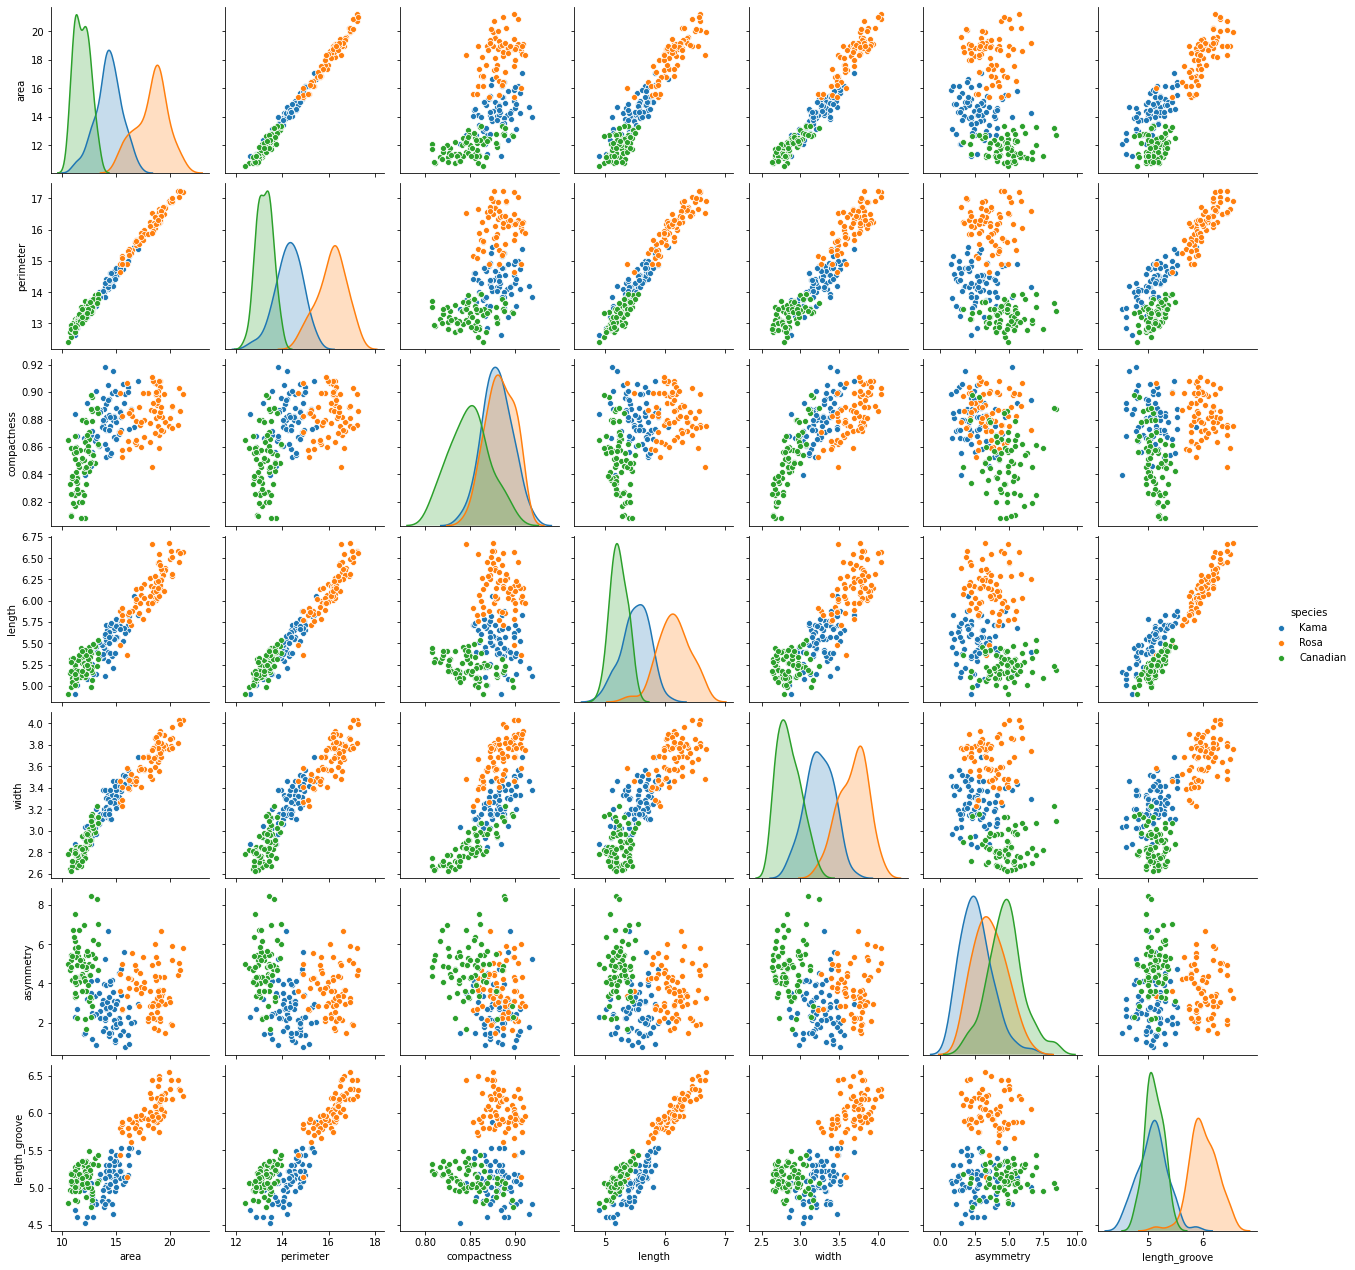

<IPython.core.display.Javascript object>

In [11]:
sns.pairplot(seeds, hue="species")
plt.show()

* Create a heatmap of the features

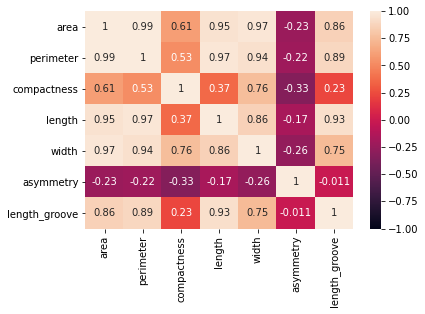

<IPython.core.display.Javascript object>

In [13]:
sns.heatmap(seeds.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

* Assess multicollinearity
    * Even though we aren't drawing a line, highly correlated features in KNN isn't good; we would be double counting the same distance between neighbors if we have 2 redundant features

In [23]:
X = seeds.drop(columns=["species", "area", "perimeter", "length", "width"])
y = seeds["species"]

<IPython.core.display.Javascript object>

In [24]:
print_vif(X)

VIF results
-------------------------------
const            1612.129598
compactness         1.190017
asymmetry           1.128930
length_groove       1.059397
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

## Model prep

* Prep the data for a KNN model to be fit

In [27]:
y.value_counts(normalize=True)

Rosa        0.333333
Canadian    0.333333
Kama        0.333333
Name: species, dtype: float64

<IPython.core.display.Javascript object>

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>

* Fit a model using `KNeighborsClassifier()`
    * Identify the best values of the `n_neighbors` and `weights` hyperparameters using `GridSearchCV()`

In [40]:
grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "weights": ["distance", "uniform"],
}

model = GridSearchCV(KNeighborsClassifier(), grid, verbose=1)
model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
                         'weights': ['distance', 'uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

<IPython.core.display.Javascript object>

In [41]:
model.score(X_train, y_train)

0.9107142857142857

<IPython.core.display.Javascript object>

In [42]:
model.score(X_test, y_test)

0.8809523809523809

<IPython.core.display.Javascript object>

* What are the best parameters?

In [43]:
model.best_params_

{'n_neighbors': 13, 'weights': 'uniform'}

<IPython.core.display.Javascript object>

* How is the model performing?

In [45]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Canadian       0.85      0.79      0.81        14
        Kama       0.80      0.86      0.83        14
        Rosa       1.00      1.00      1.00        14

    accuracy                           0.88        42
   macro avg       0.88      0.88      0.88        42
weighted avg       0.88      0.88      0.88        42



<IPython.core.display.Javascript object>

In [47]:
confusion_matrix(y_test, y_pred)

array([[11,  3,  0],
       [ 2, 12,  0],
       [ 0,  0, 14]])

<IPython.core.display.Javascript object>